###Pre Requisites

In [ ]:
#Dependencies
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117 #For installation errors - pip install wheel setuptools pip --upgrade
!pip install git+https://github.com/facebookresearch/segment-anything.git
!pip install opencv-python pycocotools matplotlib onnxruntime onnx

In [ ]:
!git clone https://github.com/IDEA-Research/GroundingDINO.git
%cd GroundingDINO/
!pip3 install -q -e .

####Model checkpoint

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
%cd ..
%mkdir Models
%cd Models
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
!wget https://huggingface.co/ShilongLiu/GroundingDINO/resolve/main/groundingdino_swinb_cogcoor.pth
!wget https://huggingface.co/ShilongLiu/GroundingDINO/resolve/main/GroundingDINO_SwinB.cfg.py
%cd ..

In [ ]:
!wget http://download.fz-juelich.de/ibg-2/Plant_Phenotyping_Datasets.zip
!unzip "Plant_Phenotyping_Datasets.zip"

In [ ]:
%mkdir "Dataset"
%cd "Dataset"
!wget https://rpf.io/p/en/astropi-ndvi-go
!unzip astropi-ndvi-go
%cd ..

In [ ]:
import torch
from segment_anything import SamPredictor, build_sam
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import matplotlib.pyplot as plt

import requests
from PIL import Image, ImageEnhance
from io import BytesIO
import os
import pandas as pd

%cd GroundingDINO/
import GroundingDINO.groundingdino.datasets.transforms as T
from GroundingDINO.groundingdino.models import build_model
from GroundingDINO.groundingdino.util import box_ops
from GroundingDINO.groundingdino.util.slconfig import SLConfig
from GroundingDINO.groundingdino.util.utils import clean_state_dict, get_phrases_from_posmap
from GroundingDINO.groundingdino.util.inference import annotate, predict

from huggingface_hub import hf_hub_download
from typing import Tuple
import math
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

[Errno 2] No such file or directory: 'GroundingDINO/'
/content/GroundingDINO


device(type='cuda')

In [ ]:
def load_dataset(path):
  images = []
  names = []
  for file_name in os.listdir(path):
      if file_name.endswith("_rgb.png"):
          image_path = os.path.join(path, file_name)
          image = Image.open(image_path).convert("RGB")
          images.append(image)
          names.append(file_name.replace("_rgb.png", ""))
  return images, names

In [ ]:
canon_img_path = "/content/Plant_Phenotyping_Datasets/Tray/Ara2013-Canon"
rpi_img_path = "/content/Plant_Phenotyping_Datasets/Tray/Ara2013-RPi"

canon_imgs, canon_names = load_dataset(canon_img_path)
print("Cannon: ",len(canon_imgs))
rpi_imgs, rpi_names = load_dataset(rpi_img_path)
print("RPi: ",len(rpi_imgs))

Cannon:  27
RPi:  27


Simple NDVI Esitmate

In [ ]:
def calculate_ndvi(red_band, green_band):
    red_array = np.array(red_band, dtype=float)
    green_array = np.array(green_band, dtype=float)
    ndvi = (green_array - red_array) / (green_array + red_array)
    return ndvi

In [ ]:
def get_results(dataset, names, colormap, path, normalization):
  ndvi_values = []
  bright = []
  health = []
  for im, name in zip(dataset, names):
    cont = ImageEnhance.Contrast(im)
    imgc = cont.enhance(1.5)
    r, g, b = imgc.split()

    ndvi = calculate_ndvi(r, g)
    dev = normalization/10
    n = np.mean(ndvi.astype(np.uint8))/dev
    ndvi_values.append(n)

    bright.append(isbright(np.asarray(im)))
    health.append(estimate_health(np.asarray(im),n))

    ndvi_normalized = ((ndvi + 1) * normalization).astype(np.uint8)
    colormapped = cv2.applyColorMap(ndvi_normalized, colormap)

    ndvi_normalized = Image.fromarray(ndvi_normalized)
    ndvi_normalized.save(os.path.join(path, f'{name}_ndvi.png'))
    ndvi_colormapped = Image.fromarray(colormapped)
    ndvi_colormapped.save(os.path.join(path, f'{name}_ndvi_colormapped.png'))

  df = pd.DataFrame({'Image Name': names, 'Mean NDVI': ndvi_values, 'Is Bright': bright, 'Status': health})
  df.to_csv(os.path.join(path, 'ndvi_mean_values.csv'), index=False)

In [ ]:
fastie = np.zeros((256, 1, 3), dtype=np.uint8)
fastie[:, 0, 2] = [255, 250, 246, 242, 238, 233, 229, 225, 221, 216, 212, 208, 204, 200, 195, 191, 187, 183, 178, 174, 170, 166, 161, 157, 153, 149, 145, 140, 136, 132, 128, 123, 119, 115, 111, 106, 102, 98, 94, 90, 85, 81, 77, 73, 68, 64, 60, 56, 52, 56, 60, 64, 68, 73, 77, 81, 85, 90, 94, 98, 102, 106, 111, 115, 119, 123, 128, 132, 136, 140, 145, 149, 153, 157, 161, 166, 170, 174, 178, 183, 187, 191, 195, 200, 204, 208, 212, 216, 221, 225, 229, 233, 238, 242, 246, 250, 255, 250, 245, 240, 235, 230, 225, 220, 215, 210, 205, 200, 195, 190, 185, 180, 175, 170, 165, 160, 155, 151, 146, 141, 136, 131, 126, 121, 116, 111, 106, 101, 96, 91, 86, 81, 76, 71, 66, 61, 56, 66, 77, 87, 98, 108, 119, 129, 140, 131, 122, 113, 105, 96, 87, 78, 70, 61, 52, 43, 35, 26, 17, 8, 0, 7, 15, 23, 31, 39, 47, 55, 63, 71, 79, 87, 95, 103, 111, 119, 127, 135, 143, 151, 159, 167, 175, 183, 191, 199, 207, 215, 223, 231, 239, 247, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255]
fastie[:, 0, 1] = [255, 250, 246, 242, 238, 233, 229, 225, 221, 216, 212, 208, 204, 200, 195, 191, 187, 183, 178, 174, 170, 166, 161, 157, 153, 149, 145, 140, 136, 132, 128, 123, 119, 115, 111, 106, 102, 98, 94, 90, 85, 81, 77, 73, 68, 64, 60, 56, 52, 56, 60, 64, 68, 73, 77, 81, 85, 90, 94, 98, 102, 106, 111, 115, 119, 123, 128, 132, 136, 140, 145, 149, 153, 157, 161, 166, 170, 174, 178, 183, 187, 191, 195, 200, 204, 208, 212, 216, 221, 225, 229, 233, 238, 242, 246, 250, 255, 250, 245, 240, 235, 230, 225, 220, 215, 210, 205, 200, 195, 190, 185, 180, 175, 170, 165, 160, 155, 151, 146, 141, 136, 131, 126, 121, 116, 111, 106, 101, 96, 91, 86, 81, 76, 71, 66, 61, 56, 66, 77, 87, 98, 108, 119, 129, 140, 147, 154, 161, 168, 175, 183, 190, 197, 204, 211, 219, 226, 233, 240, 247, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 249, 244, 239, 233, 228, 223, 217, 212, 207, 201, 196, 191, 185, 180, 175, 170, 164, 159, 154, 148, 143, 138, 132, 127, 122, 116, 111, 106, 100, 95, 90, 85, 79, 74, 69, 63, 58, 53, 47, 42, 37, 31, 26, 21, 15, 10, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
fastie[:, 0, 0] = [255, 250, 246, 242, 238, 233, 229, 225, 221, 216, 212, 208, 204, 200, 195, 191, 187, 183, 178, 174, 170, 166, 161, 157, 153, 149, 145, 140, 136, 132, 128, 123, 119, 115, 111, 106, 102, 98, 94, 90, 85, 81, 77, 73, 68, 64, 60, 56, 52, 56, 60, 64, 68, 73, 77, 81, 85, 90, 94, 98, 102, 106, 111, 115, 119, 123, 128, 132, 136, 140, 145, 149, 153, 157, 161, 166, 170, 174, 178, 183, 187, 191, 195, 200, 204, 208, 212, 216, 221, 225, 229, 233, 238, 242, 246, 250, 255, 250, 245, 240, 235, 230, 225, 220, 215, 210, 205, 200, 195, 190, 185, 180, 175, 170, 165, 160, 155, 151, 146, 141, 136, 131, 126, 121, 116, 111, 106, 101, 96, 91, 86, 81, 76, 71, 66, 61, 56, 80, 105, 130, 155, 180, 205, 230, 255, 239, 223, 207, 191, 175, 159, 143, 127, 111, 95, 79, 63, 47, 31, 15, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 15, 31, 47, 63, 79, 95, 111, 127, 143, 159, 175, 191, 207, 223, 239]

In [ ]:
get_results(canon_imgs, canon_names, fastie, canon_img_path, 150)
get_results(rpi_imgs, rpi_names, fastie, rpi_img_path, 150)

<ipython-input-8-14f8470c400a>:4: RuntimeWarning: invalid value encountered in true_divide
  ndvi = (green_array - red_array) / (green_array + red_array)
<ipython-input-8-14f8470c400a>:4: RuntimeWarning: invalid value encountered in true_divide
  ndvi = (green_array - red_array) / (green_array + red_array)


In [ ]:
data = pd.read_csv(canon_img_path + "/ndvi_mean_values.csv")
data.min()

Image Name    ara2013_tray01
Mean NDVI           0.249897
dtype: object

In [ ]:
data = pd.read_csv(rpi_img_path + "/ndvi_mean_values.csv")
data.max()

Image Name    ara2013_tray27
Mean NDVI            0.40085
dtype: object

Segmented NDVI

In [ ]:
def load_image(image_path: str) -> Tuple[np.array, torch.Tensor]:
    transform = T.Compose(
        [
            T.RandomResize([800], max_size=1333),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    )
    image_source = Image.open(image_path).convert("RGB")
    image_source.thumbnail((800,800))
    image = np.asarray(image_source)
    image_transformed, _ = transform(image_source, None)
    return image, image_transformed

In [ ]:
def load_images(path):
  images = []
  image_sources = []
  names = []
  for file_name in os.listdir(path):
    if file_name.endswith("_rgb.png"):
      image_path = os.path.join(path, file_name)
      image_source, image = load_image(image_path)
      image_sources.append(image_source)
      images.append(image)
      names.append(file_name.replace("_rgb.png", ""))
  return image_sources, images, names

In [ ]:
canon_img_sources, canon_imgs, canon_names = load_images(canon_img_path)
print("Cannon: ",len(canon_imgs))
rpi_img_sources, rpi_imgs, rpi_names = load_images(rpi_img_path)
print("RPi: ",len(rpi_imgs))

Cannon:  27
RPi:  27


In [ ]:
def load_model(path, config, device='cpu'):
    args = SLConfig.fromfile(config)
    args.device = device
    model = build_model(args)

    checkpoint = torch.load(path, map_location=device)
    log = model.load_state_dict(clean_state_dict(checkpoint['model']), strict=False)
    print("Model loaded from {} \n => {}".format(path, log))
    _ = model.eval()
    return model

gdmodel = load_model("/content/Models/groundingdino_swinb_cogcoor.pth", "/content/Models/GroundingDINO_SwinB.cfg.py", device)

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model loaded from /content/Models/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight'])


In [ ]:
def detect_plants(image_sources, images, names, path, gdmodel):
  frames = []
  box_list = []
  plants = []
  for image_source, image, name in zip(image_sources, images, names):
    boxes, logits, phrases = predict(model = gdmodel, image = image, caption = "plant", box_threshold = 0.3, text_threshold = 0.25)
    frame = annotate(image_source = image_source, boxes = boxes, logits = logits, phrases = phrases)
    frame = frame[...,::-1]
    frames.append(frame)
    box_list.append(boxes)
    plants.append(len(boxes))
    img = Image.fromarray(frame)
    img.save(os.path.join(path, f'{name}_boxed.png'))
  df = pd.DataFrame({'Image Name': names, 'Number of plants detected': plants})
  df.to_csv(os.path.join(path, 'GD_plants_detected.csv'), index=False)
  return frames, box_list

In [ ]:
canon_img_frames, canon_img_boxes = detect_plants(canon_img_sources, canon_imgs, canon_names, canon_img_path, gdmodel)
rpi_img_frames, rpi_img_boxes = detect_plants(rpi_img_sources, rpi_imgs, rpi_names, rpi_img_path, gdmodel)

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:884: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:884: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:884: FutureWarning: The `device` argument is deprecated and will be removed in v5 o

In [ ]:
data = pd.read_csv(canon_img_path + "/GD_plants_detected.csv")
temp = data[data['Number of plants detected'] != 24]
temp.head()

,Image Name,Number of plants detected
0,ara2013_tray14,25
3,ara2013_tray27,26
5,ara2013_tray03,25
16,ara2013_tray06,25
20,ara2013_tray16,25


In [ ]:
sam = SamPredictor(build_sam(checkpoint="/content/Models/sam_vit_h_4b8939.pth").to(device))

In [ ]:
def segment(image, sam_model, boxes):
  sam_model.set_image(image)
  H, W, _ = image.shape
  boxes_xyxy = box_ops.box_cxcywh_to_xyxy(boxes) * torch.Tensor([W, H, W, H])

  transformed_boxes = sam_model.transform.apply_boxes_torch(boxes_xyxy.to(device), image.shape[:2])
  masks, _, _ = sam_model.predict_torch(
      point_coords = None,
      point_labels = None,
      boxes = transformed_boxes,
      multimask_output = False,
      )
  return masks.cpu()

#segmented_frame_masks = segment(image_source, sam, boxes=boxes)
#Image.fromarray(segmented_frame_masks[3][0].numpy())

In [ ]:
def draw_mask(mask, image):
    color = np.array([1, 1, 1, 1])
    dark_image = np.array(image)
    dark_image_pil = Image.fromarray(dark_image.astype(np.uint8)).convert("RGBA")
    result_image = Image.new("RGBA", dark_image_pil.size, (0, 0, 0, 0))

    for i, m in enumerate(mask.numpy()):
        h, w = m.shape[-2:]
        mask_image = m.reshape(h, w, 1) * color.reshape(1, 1, -1)
        mask_image_pil = Image.fromarray((mask_image * 255).astype(np.uint8)).convert("RGBA")
        result_image.paste(mask_image_pil, (0, 0), mask_image_pil)

    return np.array(result_image)

#annotated_frame_with_mask = draw_mask(segmented_frame_masks[3][0], frame)
#Image.fromarray(annotated_frame_with_mask)

In [ ]:
def get_segmented_plants(sources, model, boxes, frames, names, path):
  masks = []
  for image, box, frame, name in zip(sources, boxes, frames, names):
    mask = segment(image,model,box)
    masks.append(mask)
    img = draw_mask(mask, image)
    img = Image.fromarray(img)
    img.save(os.path.join(path, f'{name}_mask.png'))
  return masks

In [ ]:
canon_img_mask = get_segmented_plants(canon_img_sources, sam, canon_img_boxes, canon_img_frames, canon_names, canon_img_path)
rpi_img_mask = get_segmented_plants(rpi_img_sources, sam, rpi_img_boxes, rpi_img_frames, rpi_names, rpi_img_path)

In [ ]:
def segmented_ndvi(sources, masks, path, normalization, names, colormap):
    data = []

    for img, mask, name in zip(sources, masks, names):
        contrasted_image = np.zeros_like(img)

        for i in range(len(mask)):
            m = mask[i][0].numpy()
            contrasted_image[np.where(m != 0)] = img[np.where(m != 0)]

        im = Image.fromarray(contrasted_image)
        cont = ImageEnhance.Contrast(im)
        imgc = cont.enhance(1.5)
        r, g, b = imgc.split()

        ndvi = calculate_ndvi(r, g)
        ndvi_normalized = ((ndvi + 1) * normalization).astype(np.uint8)

        for i in range(len(mask)):
            m = mask[i][0].numpy()
            plant_ndvi_value = []
            h, w = m.shape

            for j in range(h):
                for k in range(w):
                    if m[j][k]:
                        plant_ndvi_value.append(ndvi_normalized.astype(np.uint8)[j][k])

            ndvi_mean = np.mean(plant_ndvi_value)/190
            data.append([name, i + 1, ndvi_mean, isbright(img), estimate_health(img, ndvi_mean)])

        colormapped = cv2.applyColorMap(ndvi_normalized, colormap)
        temp = Image.fromarray(ndvi_normalized)
        temp.save(os.path.join(path, f'{name}_segmented_ndvi.png'))
        temp = Image.fromarray(colormapped)
        temp.save(os.path.join(path, f'{name}_segmented_colormapped.png'))

    df = pd.DataFrame(data, columns=["Image Name", "Plant Number", "Mean NDVI", "Is Bright", "Status"])
    csv_path = os.path.join(path, "segmented_ndvi.csv")
    df.to_csv(csv_path, index=False)

In [ ]:
data = pd.read_csv(rpi_img_path + "/segmented_ndvi.csv")
temp = data[data['Mean NDVI'] > 0.95]
temp.head()

,Image Name,Plant Number,Mean NDVI
69,ara2013_tray26,20,0.972378
78,ara2013_tray27,5,0.970778
80,ara2013_tray27,7,0.957486
651,ara2013_tray24,23,0.951258


In [ ]:
segmented_ndvi(canon_img_sources, canon_img_mask, canon_img_path, 150, canon_names, fastie)
segmented_ndvi(rpi_img_sources, rpi_img_mask, rpi_img_path, 150, rpi_names, fastie)

Normalized predictor

In [ ]:
def chromcoords(image):
    # Convert the image to the CIE XYZ color space
    xyz_image = cv2.cvtColor(image, cv2.COLOR_BGR2XYZ)

    # Extract the X, Y, Z channels
    X = xyz_image[:, :, 0]
    Y = xyz_image[:, :, 1]
    Z = xyz_image[:, :, 2]

    # Calculate the chromaticity coordinates
    epsilon = 1e-10
    x = X / (X + Y + Z + epsilon)
    y = Y / (X + Y + Z + epsilon)

    # Calculate the inverse of the chromaticity coordinates
    u = 4 * x / (-2 * x + 12 * y + 3)
    v = 6 * y / (-2 * x + 12 * y + 3)


    u=np.mean(u)
    v=np.mean(v)

    d65_x=0.31272
    d65_y=0.32903

    if u>d65_x or v>d65_y:
      return True
    return False

In [ ]:
def isbright(image, dim=10):
   # Resize image to 10x10
    image = cv2.resize(image, (dim, dim))
     # Convert color space to LAB format and extract L channel
    L, A, B = cv2.split(cv2.cvtColor(image, cv2.COLOR_BGR2LAB))
    # Normalize L channel by dividing all pixel values with maximum pixel value
    L = L/np.max(L)
    L=np.mean(L)
    L_flag= False if L<=0.7 else True

    xyz_image = cv2.cvtColor(image, cv2.COLOR_BGR2XYZ)

    X, Y, Z= cv2.split(xyz_image)
    Y = Y/np.max(Y)
    Y=np.mean(Y)
    Y_flag = False if Y<=0.7 else True

    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # Split the HSV image into channels
    h, s, v = cv2.split(hsv_image)

    # Normalize v channel by dividing all pixel values with maximum pixel value
    v = v/np.max(v)
    v=np.mean(v)

    v_flag = False if v<=0.7 else True

    uv_flag = chromcoords(image)

    if L_flag or Y_flag or v_flag or uv_flag:
      return True
    return False

In [ ]:
def estimate_health(image, ndvi):
  if isbright(image):

    if ndvi>=0.8:
      return "Healthy"
    else:
      return "Unhealthy"

  else:
    if ndvi>=0.33:
      return "Healthy"
    else:
      return "Unhealthy"

Graphical inferences

In [ ]:
import pandas as pd
from matplotlib.pyplt import plt

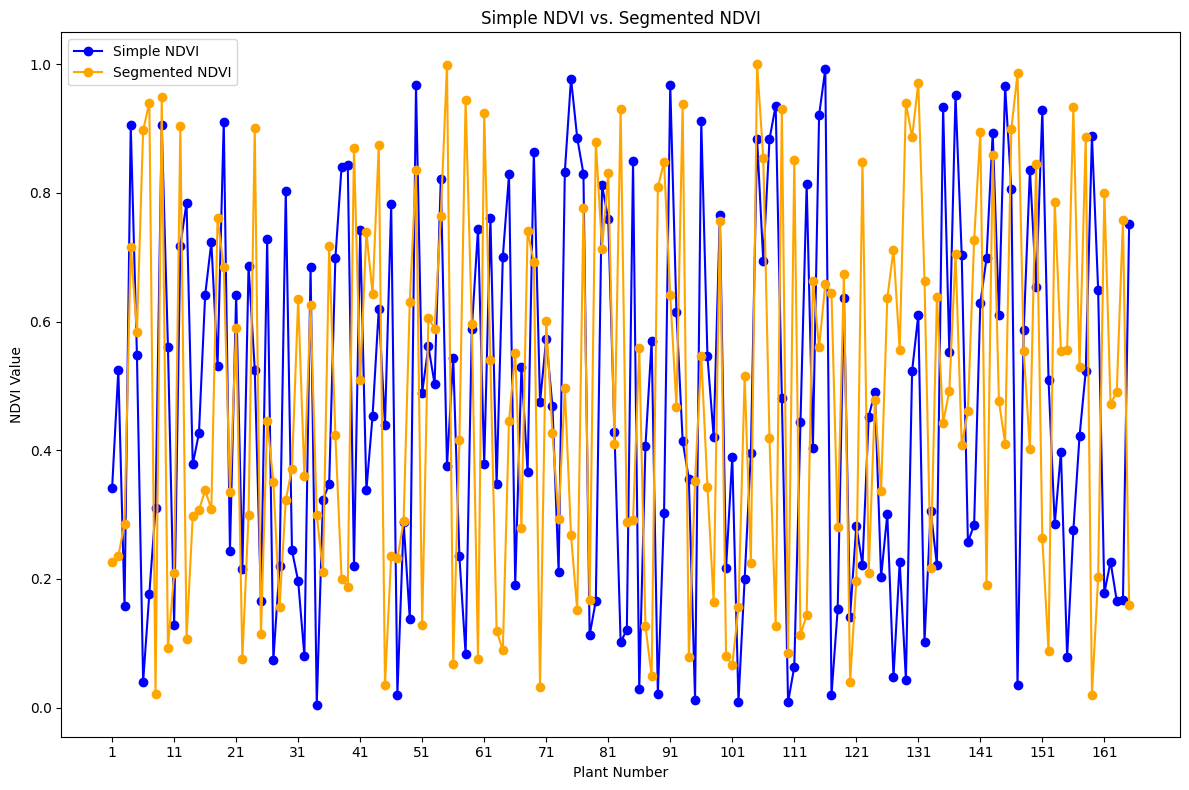

In [ ]:
def plot_ndvi_comparison(csv_data):
    plant_numbers = [row[0] for row in csv_data[1:]]
    cameras = [row[1] for row in csv_data[1:]]
    simple_ndvi = [row[2] for row in csv_data[1:]]
    segmented_ndvi = [row[3] for row in csv_data[1:]]

    plt.figure(figsize=(12, 8))
    plt.plot(plant_numbers, simple_ndvi, label="Simple NDVI", marker='o', color="blue")
    plt.plot(plant_numbers, segmented_ndvi, label="Segmented NDVI", marker='o', color="orange")
    plt.xlabel("Plant Number")
    plt.ylabel("NDVI Value")
    plt.title("Simple NDVI vs. Segmented NDVI")
    plt.legend()
    plt.xticks(np.arange(1, 166, step=10))
    plt.tight_layout()
    plt.show()

plot_ndvi_comparison(csv_data)

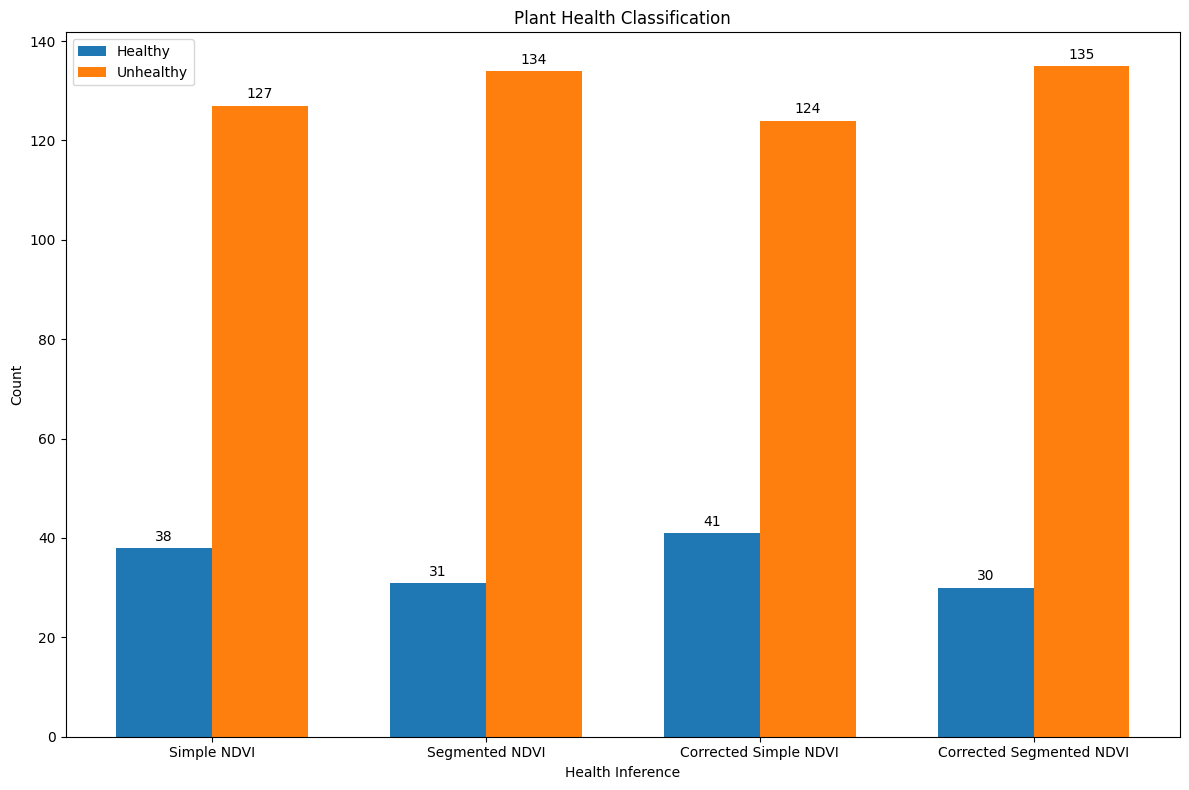

In [ ]:
def plot_health_classification(health_data):
    plant_numbers = [row[0] for row in health_data[1:]]
    cameras = [row[1] for row in health_data[1:]]
    inference1 = [row[2] for row in health_data[1:]]
    inference2 = [row[3] for row in health_data[1:]]
    inference3 = [row[4] for row in health_data[1:]]
    inference4 = [row[5] for row in health_data[1:]]

    healthy_counts = []
    unhealthy_counts = []
    labels = ["Simple NDVI", "Segmented NDVI", "Corrected Simple NDVI", "Corrected Segmented NDVI"]

    for inference in [inference1, inference2, inference3, inference4]:
        healthy_counts.append(inference.count("Healthy"))
        unhealthy_counts.append(inference.count("Unhealthy"))

    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots(figsize=(12, 8))
    rects1 = ax.bar(x - width/2, healthy_counts, width, label='Healthy')
    rects2 = ax.bar(x + width/2, unhealthy_counts, width, label='Unhealthy')

    ax.set_xlabel('Health Inference')
    ax.set_ylabel('Count')
    ax.set_title('Plant Health Classification')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    plt.tight_layout()
    plt.show()

plot_health_classification(health_data)

In [ ]:
from google.colab import files
!zip -r /content/results.zip /content/Plant_Phenotyping_Datasets
files.download("/content/results.zip")